### Q1: Exploratory Data Analysis (5 Pts)
Get familiar with the dataset by exploring the different features, their distribution, and the labels.
Check for common pitfalls like missing or nonsensical data, unusual feature distribution, outliers,
or class imbalance, and describe how to handle them. After having familiarized yourself with the
data, explain how you preprocess the dataset for the remaining tasks of part 1. Interpretabilityand explainability aim at gaining more insights about the data than just optimizing predictive
performance. A first simple step is to have a look at the (linear) dependencies of the variables.
Visualize the pairwise correlation matrix and describe which features seem to be important for
predicting the label.

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
data_frame = pd.read_csv("/home/omkar/ethz/fs23/ml4hc/project1/heart_failure/heart.csv")

In [290]:
data_frame.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [291]:
print("Shape:", data_frame.shape)
print("#positive samples: ", len(data_frame.HeartDisease[data_frame.HeartDisease == 1]))
print("#negative samples: ", len(data_frame.HeartDisease[data_frame.HeartDisease == 0]))

Shape: (918, 12)
#positive samples:  508
#negative samples:  410


As we can see, there are slightly more positive samples than negative ones - but the labels are still fairly balanced.
We now look for missing values: //TO-DO cholesterol seems to have some 0s - probably missing values : impute them or delete?

We note that the following columns are categorical, hence convert their dtype from `object` to `category`

In [292]:
data_frame.Sex.unique(), data_frame.ChestPainType.unique(), data_frame.RestingECG.unique(), data_frame.ExerciseAngina.unique(), data_frame.ST_Slope.unique()

(array(['M', 'F'], dtype=object),
 array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object),
 array(['Normal', 'ST', 'LVH'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Up', 'Flat', 'Down'], dtype=object))

In [293]:
data_frame.Sex = data_frame.Sex.astype("category")
data_frame.ChestPainType = data_frame.ChestPainType.astype("category")
data_frame.RestingECG = data_frame.RestingECG.astype("category")
data_frame.ExerciseAngina = data_frame.ExerciseAngina.astype("category")
data_frame.ST_Slope = data_frame.ST_Slope.astype("category")
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    int64   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(5), float64(1), int64(6)
memory usage: 55.5 KB


/tmp/ipykernel_14034/378703819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame["Cholesterol"][data_frame.Cholesterol[data_frame.Cholesterol == 0].index] = zero_excluded_mean


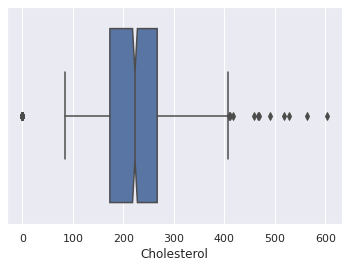

In [294]:
sns.boxplot(data=data_frame, x="Cholesterol", notch=True)
zero_excluded_mean = data_frame.Cholesterol[data_frame.Cholesterol != 0].mean()
data_frame["Cholesterol"][data_frame.Cholesterol[data_frame.Cholesterol == 0].index] = zero_excluded_mean

<Axes: xlabel='RestingBP'>

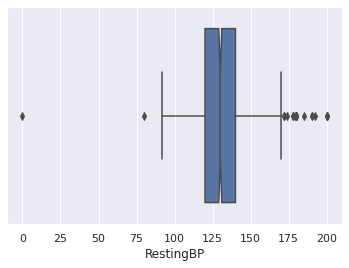

In [295]:
sns.boxplot(data=data_frame, x="RestingBP", notch=True)

<Axes: xlabel='RestingBP'>

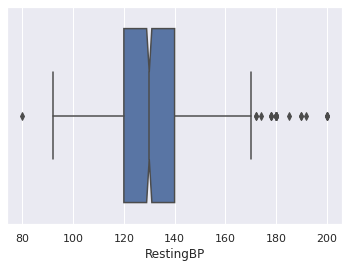

In [296]:

data_frame = data_frame.drop(data_frame.RestingBP[data_frame.RestingBP < 75].index)
data_frame.describe()
sns.boxplot(data=data_frame, x="RestingBP", notch=True)

<Axes: xlabel='Cholesterol'>

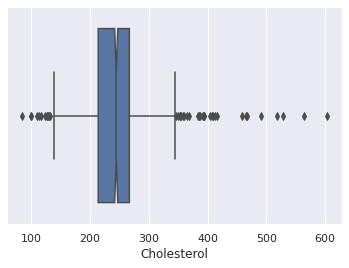

In [297]:
sns.boxplot(data=data_frame, x="Cholesterol", notch=True)

#### Visualizing pairwise correlation
We see that high values of Age, Cholesterol, FastingBS, OldPeak and low values of MaxHR are predictive of HeartDisease. We also see the inter-feature correlation in the plotted heatmap.

/tmp/ipykernel_14034/604118848.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_frame.corr()


<Axes: >

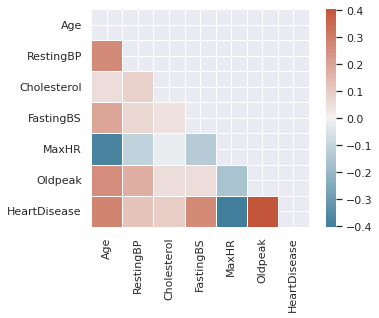

In [298]:
#sns.pairplot(data=data_frame, hue="HeartDisease")
corr = data_frame.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5)

### Q2: Logistic Lasso Regression

In [299]:
target_label = data_frame.pop("HeartDisease")


In [300]:
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#standardized_data = StandardScaler().fit(data_frame)
#standardized_data.info()
data_frame.info()
categorical_columns = data_frame.select_dtypes('category').columns
data_frame[categorical_columns] = data_frame[categorical_columns].apply(lambda x: x.cat.codes)
lr_classifier = LogisticRegression(solver='saga', penalty='l1', max_iter=10000).fit(data_frame, target_label)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             917 non-null    int64   
 1   Sex             917 non-null    category
 2   ChestPainType   917 non-null    category
 3   RestingBP       917 non-null    int64   
 4   Cholesterol     917 non-null    float64 
 5   FastingBS       917 non-null    int64   
 6   RestingECG      917 non-null    category
 7   MaxHR           917 non-null    int64   
 8   ExerciseAngina  917 non-null    category
 9   Oldpeak         917 non-null    float64 
 10  ST_Slope        917 non-null    category
dtypes: category(5), float64(2), int64(4)
memory usage: 55.3 KB


In [301]:
predictions = lr_classifier.predict_proba(data_frame)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.sum(predicted_labels == target_label) / len(target_label)
print("Accuracy: %f" % accuracy)

Accuracy: 0.837514


In [302]:
test_frame = pd.read_csv("/home/omkar/ethz/fs23/ml4hc/project1/heart_failure/test_split.csv")
test_frame[categorical_columns] = test_frame[categorical_columns].astype('category')
test_frame[categorical_columns] = test_frame[categorical_columns].apply(lambda x: x.cat.codes)
test_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             184 non-null    int64  
 1   Sex             184 non-null    int8   
 2   ChestPainType   184 non-null    int8   
 3   RestingBP       184 non-null    int64  
 4   Cholesterol     184 non-null    int64  
 5   FastingBS       184 non-null    int64  
 6   RestingECG      184 non-null    int8   
 7   MaxHR           184 non-null    int64  
 8   ExerciseAngina  184 non-null    int8   
 9   Oldpeak         184 non-null    float64
 10  ST_Slope        184 non-null    int8   
 11  HeartDisease    184 non-null    int64  
dtypes: float64(1), int64(6), int8(5)
memory usage: 11.1 KB


In [303]:
test_target = test_frame.pop("HeartDisease")
predictions = lr_classifier.predict_proba(test_frame)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.sum(predicted_labels == test_target) / len(test_target)
print("Accuracy: %f" % accuracy)

Accuracy: 0.809783


In [304]:
lr_classifier.coef_

array([[ 0.02579116,  0.61862059, -0.61572474,  0.00501104,  0.00328111,
         0.51413717,  0.02273066, -0.01494   ,  0.60772175,  0.53889332,
        -0.97705975]])